In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import os
from tqdm import tqdm
from statsmodels.stats import proportion

import seaborn as sns
sns.set_style("whitegrid")

colors = sns.color_palette("deep")

In [3]:
def generate_data(n_users, success_rate, beta, uplift=0):
    mean = success_rate * (1 + uplift)
    alpha = (mean * beta) / (1 - mean)
    
    user_ctrs = np.random.beta(alpha, beta, size=n_users)
    views = np.random.lognormal(mean=1, sigma=2.0, size=n_users).astype(int) + 1
    clicks = np.random.binomial(n=views, p=user_ctrs)
    
    return views, clicks, user_ctrs


def bootstrap(ctrs_0, weights_0, ctrs_1, weights_1, n_bootstrap=2000):
    poisson_bootstraps = stats.poisson(1).rvs((n_bootstrap, ctrs_0.shape[1])).astype(np.int64)

    values_0 = np.matmul(ctrs_0 * weights_0, poisson_bootstraps.T)
    weights_0 = np.matmul(weights_0, poisson_bootstraps.T)

    values_1 = np.matmul(ctrs_1 * weights_1, poisson_bootstraps.T)
    weights_1 = np.matmul(weights_1, poisson_bootstraps.T)

    deltas = values_1 / weights_1 - values_0 / weights_0

    positions = np.sum(deltas < 0, axis=1)

    return 2 * np.minimum(positions, n_bootstrap - positions) / n_bootstrap


def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=2000):
    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(int)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return stats.ttest_ind(values_0, values_1).pvalue

In [4]:
N = 5000
success_rate = 0.02
beta = 250
uplift = 0.2

# Группа А (Контроль)
views_a, clicks_a, user_ctrs_a = generate_data(N, success_rate, beta)

# Группа B (Тест)
views_b, clicks_b, user_ctrs_b = generate_data(N, success_rate, beta, uplift = uplift)

print(f"Группа A: Средний CTR = {clicks_a.sum() / views_a.sum():.4f}")
print(f"Группа B: Средний CTR = {clicks_b.sum() / views_b.sum():.4f}")

Группа A: Средний CTR = 0.0206
Группа B: Средний CTR = 0.0230


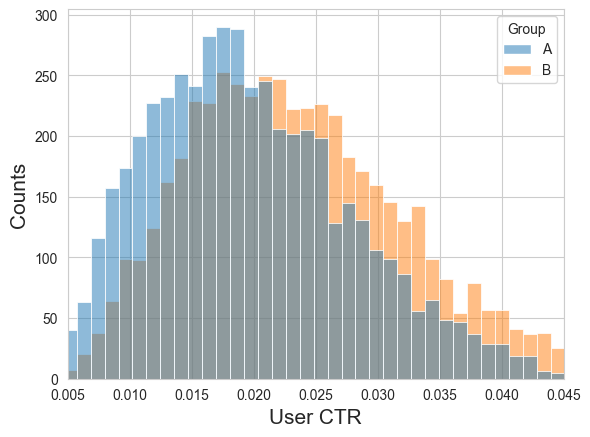

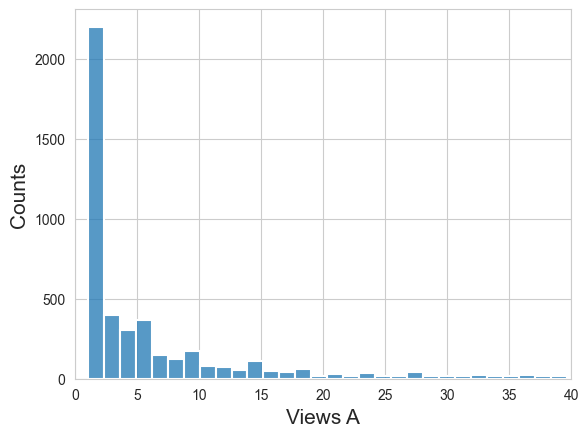

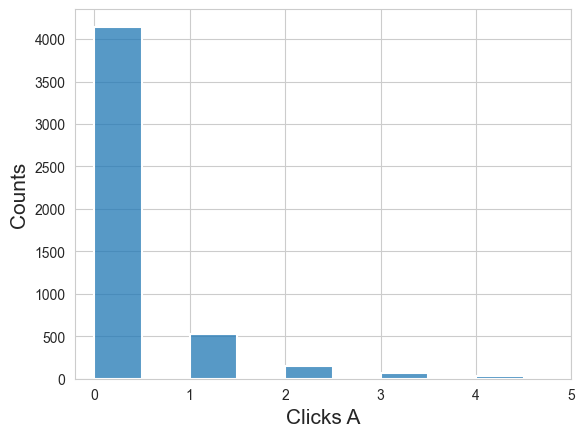

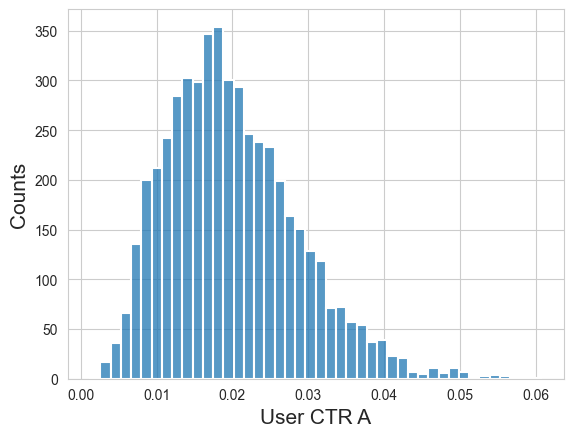

In [5]:
A = pd.DataFrame({"Group": "A", "Views": views_a, "Clicks": clicks_a, "User_CTR": user_ctrs_a})
B = pd.DataFrame({"Group": "B", "Views": views_b, "Clicks": clicks_b, "User_CTR": user_ctrs_b})
df = pd.concat([A, B], ignore_index=True)
sns.histplot(df, x = 'User_CTR', hue='Group')
plt.xlabel('User CTR', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.xlim(0.005, 0.045)
plt.savefig('CTR_AB.png', dpi=300, bbox_inches='tight') 
plt.show()

sns.histplot(x = views_a, bins=2400, edgecolor='white', linewidth = 1.5)
plt.xlim(0, 40)
plt.xlabel('Views A', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('Counts_A.png', dpi=300, bbox_inches='tight') 
plt.show()

sns.histplot(x = clicks_a, edgecolor='white', linewidth = 1.5)
plt.xlim(-0.2, 5)
plt.xlabel('Clicks A', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('Clicks_A.png', dpi=300, bbox_inches='tight') 
plt.show()

sns.histplot(x = user_ctrs_a, edgecolor='white', linewidth = 1.5)
plt.xlabel('User CTR A', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('CTR_A.png', dpi=300, bbox_inches='tight') 
plt.show()

In [8]:
alpha = 0.05

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 362.01it/s]


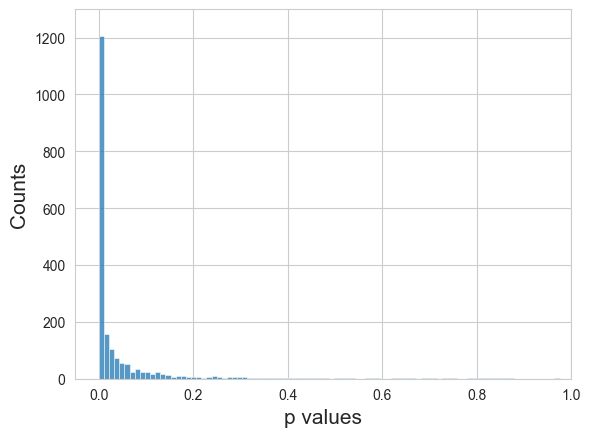

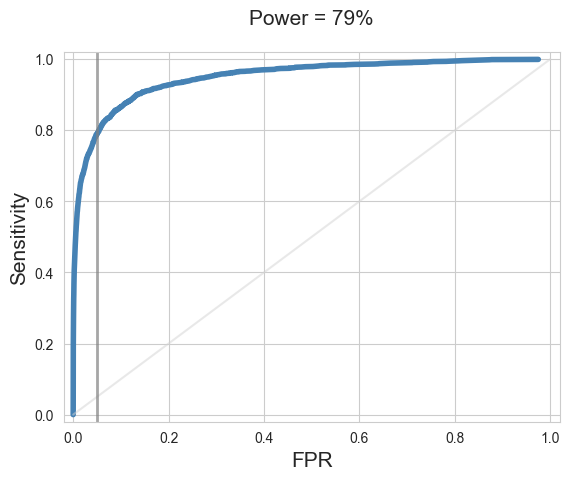

In [7]:
#A/B тест (тест Манна-Уитни)

NN = 2000
pvalues = []
cnt = 0
#Monte-Carlo
for _ in tqdm(range(NN)):
    views_a, clicks_a, user_ctrs_a = generate_data(N, success_rate, beta)
    views_b, clicks_b, user_ctrs_b = generate_data(N, success_rate, beta, uplift=uplift)
    reg = stats.mannwhitneyu(clicks_a, clicks_b)
    cnt += (reg.pvalue < alpha)
    pvalues.append(reg.pvalue)

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 1300)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_mannwhitneyu.png', dpi=300, bbox_inches='tight') 
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_mannwhitneyu.png', dpi=300, bbox_inches='tight')  
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.43it/s]


0.0425
(0.03450117971009799, 0.05225291855224844)


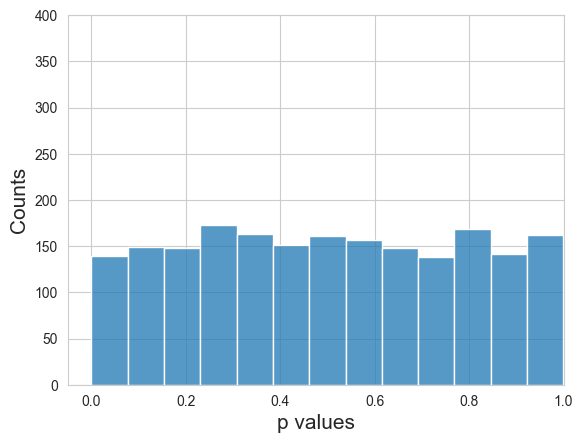

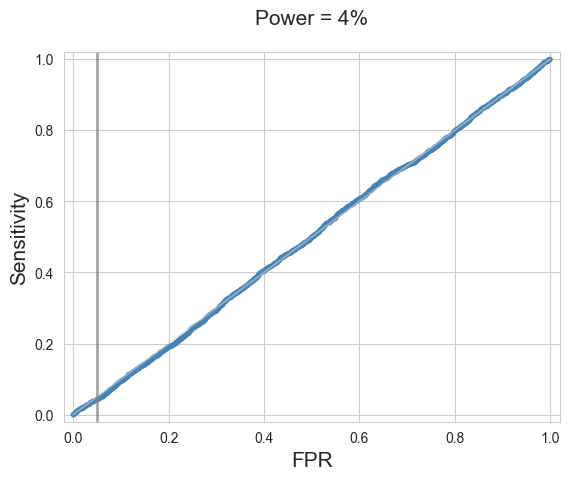

In [18]:
#A/A тест (тест Манна-Уитни)

NN = 2000
pvalues = []
cnt = 0
#Monte-Carlo
for _ in tqdm(range(NN)):
    views_a, clicks_a, user_ctrs_a = generate_data(N, success_rate, beta)
    views_b, clicks_b, user_ctrs_b = generate_data(N, success_rate, beta)
    reg = stats.mannwhitneyu(clicks_a, clicks_b)
    cnt += (reg.pvalue < alpha)
    pvalues.append(reg.pvalue)
print(np.mean(np.array(pvalues) < alpha))
print(proportion.proportion_confint(count = cnt, nobs = NN, alpha=0.05, method='wilson'))

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 400)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_mannwhitneyu_AA.png', dpi=300, bbox_inches='tight') 
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_mannwhitneyu_AA.png', dpi=300, bbox_inches='tight')  
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 391.25it/s]


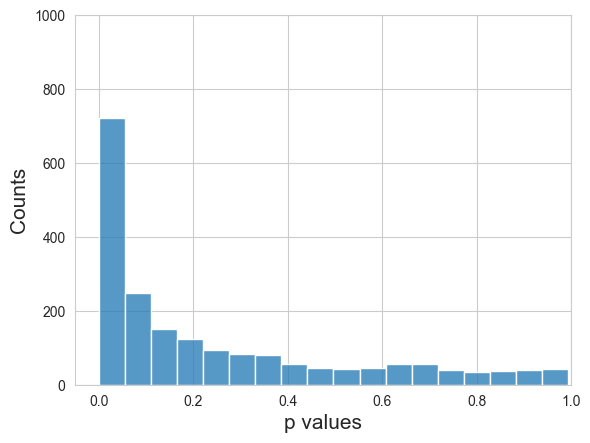

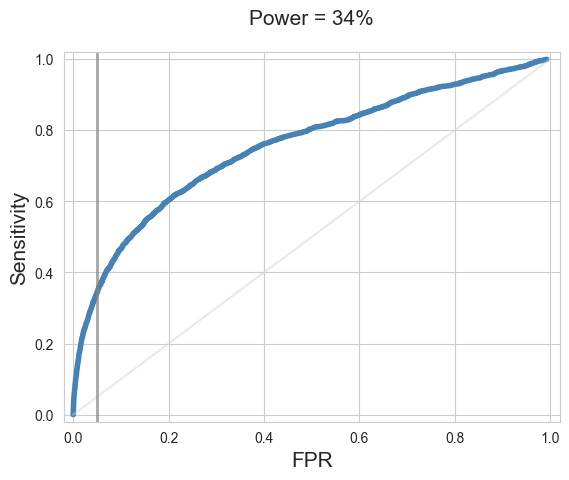

In [10]:
#A/B тест (t тест)

NN = 2000
pvalues = []

#Monte-Carlo
for _ in tqdm(range(NN)):
    views_a, clicks_a, user_ctrs_a = generate_data(N, success_rate, beta)
    views_b, clicks_b, user_ctrs_b = generate_data(N, success_rate, beta, uplift=uplift)
    reg = stats.ttest_ind(clicks_a, clicks_b)
    pvalues.append(reg.pvalue)

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 1000)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_t.png', dpi=300, bbox_inches='tight')  
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_t.png', dpi=300, bbox_inches='tight')  
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 399.31it/s]


0.0435
(0.03540128785854411, 0.0533489763092398)


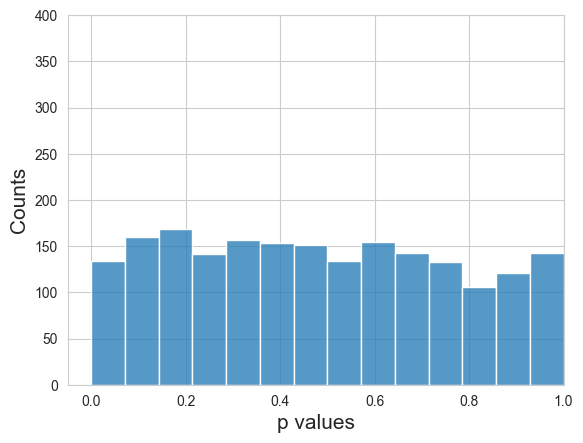

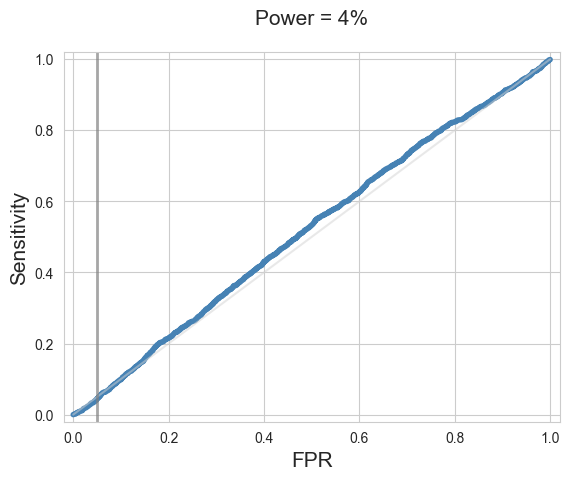

In [19]:
#A/A тест (t тест)

NN = 2000
pvalues = []
cnt = 0
#Monte-Carlo
for _ in tqdm(range(NN)):
    views_a, clicks_a, user_ctrs_a = generate_data(N, success_rate, beta)
    views_b, clicks_b, user_ctrs_b = generate_data(N, success_rate, beta)
    reg = stats.ttest_ind(clicks_a, clicks_b)
    cnt += (reg.pvalue < alpha)
    pvalues.append(reg.pvalue)
print(np.mean(np.array(pvalues) < alpha))
print(proportion.proportion_confint(count = cnt, nobs = NN, alpha=0.05, method='wilson'))

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 400)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_t_AA.png', dpi=300, bbox_inches='tight')  
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_t_AA.png', dpi=300, bbox_inches='tight')   
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 586.51it/s]


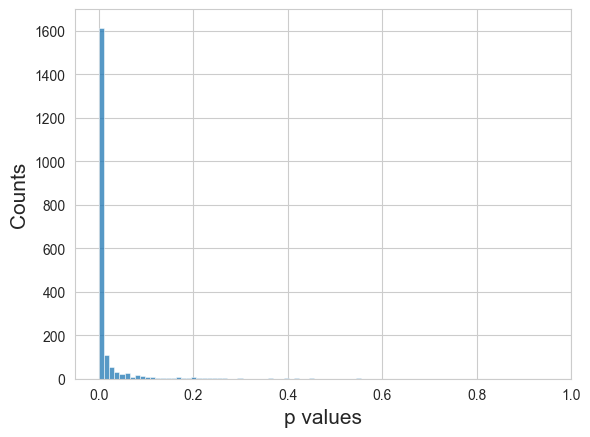

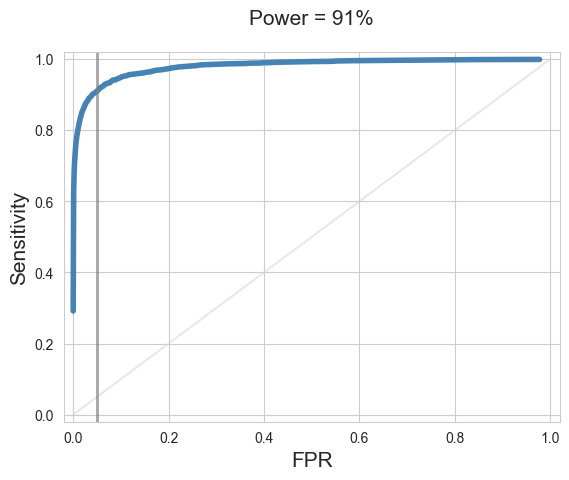

In [12]:
#A/B тест (Poisson bootsrtap)

NN = 2000
all_ctrs_a = np.zeros((NN, N))
all_weights_a = np.zeros((NN, N))
all_ctrs_b = np.zeros((NN, N))
all_weights_b = np.zeros((NN, N))
#Монте-Карло
for i in tqdm(range(NN)):
    views_a, clicks_a, _ = generate_data(N, success_rate, beta, uplift=0)
    views_b, clicks_b, _ = generate_data(N, success_rate, beta, uplift=uplift)
    all_ctrs_a[i, :] = clicks_a / views_a
    all_weights_a[i, :] = views_a
    all_ctrs_b[i, :] = clicks_b / views_b
    all_weights_b[i, :] = views_b
 
pvalues = bootstrap(all_ctrs_a, all_weights_a, all_ctrs_b, all_weights_b, NN)

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 1700)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_bootstrap.png', dpi=300, bbox_inches='tight')  
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_bootstrap.png', dpi=300, bbox_inches='tight')  
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 595.62it/s]


0.0595
(0.04995260683841223, 0.07073631181637159)


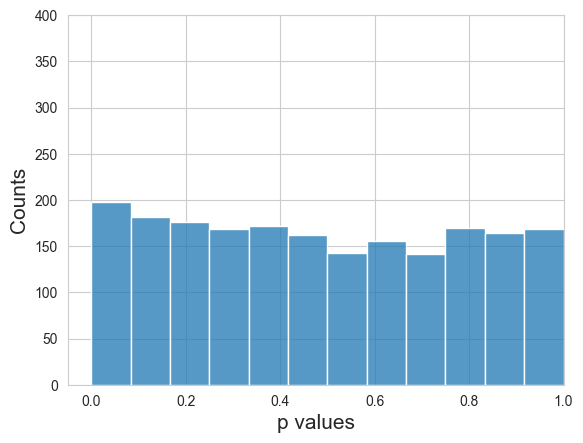

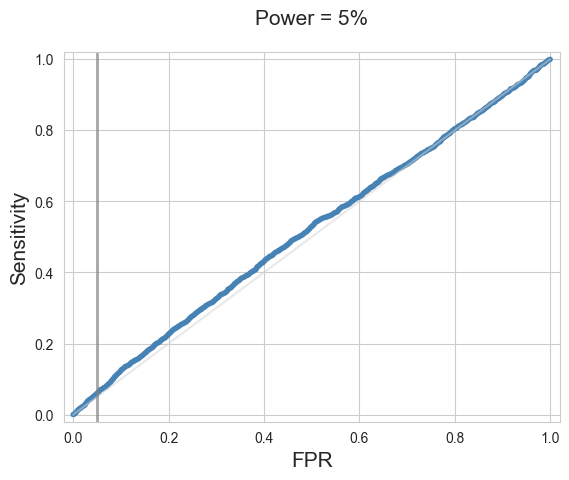

In [20]:
#A/A тест (Poisson bootsrtap)

NN = 2000
all_ctrs_a = np.zeros((NN, N))
all_weights_a = np.zeros((NN, N))
all_ctrs_b = np.zeros((NN, N))
all_weights_b = np.zeros((NN, N))
#Монте-Карло
for i in tqdm(range(NN)):
    views_a, clicks_a, _ = generate_data(N, success_rate, beta)
    views_b, clicks_b, _ = generate_data(N, success_rate, beta)
    all_ctrs_a[i, :] = clicks_a / views_a
    all_weights_a[i, :] = views_a
    all_ctrs_b[i, :] = clicks_b / views_b
    all_weights_b[i, :] = views_b
 
pvalues = bootstrap(all_ctrs_a, all_weights_a, all_ctrs_b, all_weights_b, NN)
print(np.mean(np.array(pvalues) < alpha))
print(proportion.proportion_confint(count = np.count_nonzero(pvalues < 0.05), nobs = NN, alpha=0.05, method='wilson'))

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 400)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_bootstrap_AA.png', dpi=300, bbox_inches='tight')  
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_bootstrap_AA.png', dpi=300, bbox_inches='tight')    
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 589.80it/s]


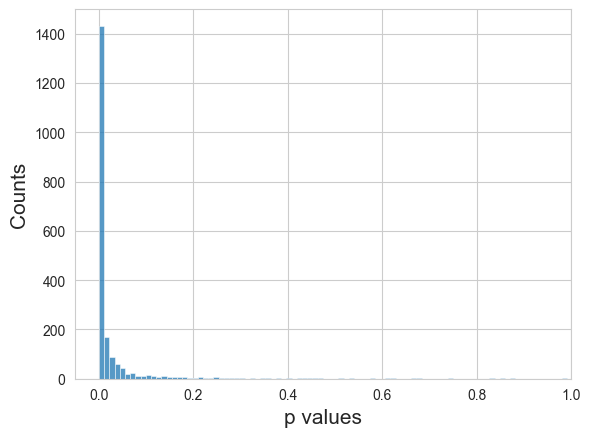

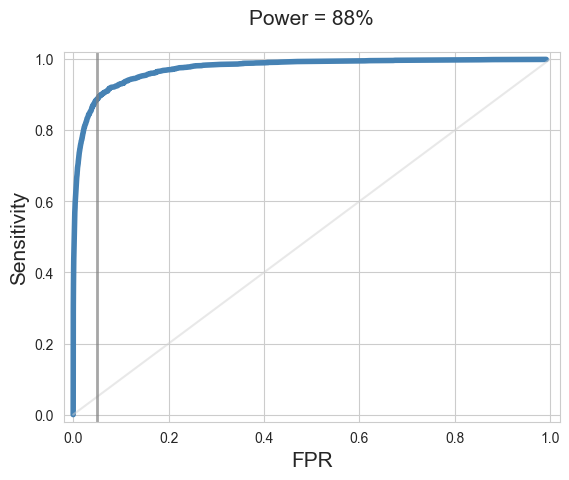

In [14]:
#A/B тест (Bucketization)

NN = 2000
all_ctrs_a = np.zeros((NN, N))
all_weights_a = np.zeros((NN, N))
all_ctrs_b = np.zeros((NN, N))
all_weights_b = np.zeros((NN, N))
#Монте-Карло
for i in tqdm(range(NN)):
    views_a, clicks_a, _ = generate_data(N, success_rate, beta, uplift=0)
    views_b, clicks_b, _ = generate_data(N, success_rate, beta, uplift=uplift)
    all_ctrs_a[i, :] = clicks_a / views_a
    all_weights_a[i, :] = views_a
    all_ctrs_b[i, :] = clicks_b / views_b
    all_weights_b[i, :] = views_b

pvalues = bucketization(all_ctrs_a, all_weights_a, all_ctrs_b, all_weights_b)

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 1500)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_bucketization.png', dpi=300, bbox_inches='tight')  
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_bucketization.png', dpi=300, bbox_inches='tight')  
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 588.47it/s]


0.0425
(0.03450117971009799, 0.05225291855224844)


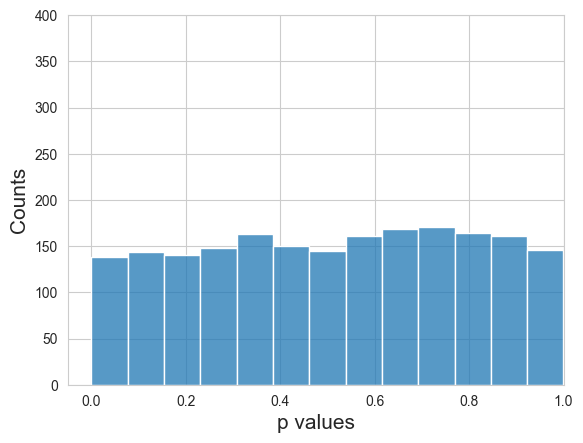

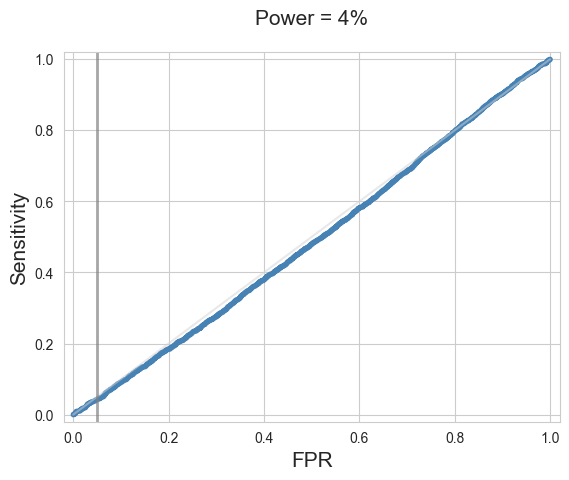

In [21]:
#A/A тест (Bucketization)

NN = 2000
all_ctrs_a = np.zeros((NN, N))
all_weights_a = np.zeros((NN, N))
all_ctrs_b = np.zeros((NN, N))
all_weights_b = np.zeros((NN, N))
#Монте-Карло
for i in tqdm(range(NN)):
    views_a, clicks_a, _ = generate_data(N, success_rate, beta)
    views_b, clicks_b, _ = generate_data(N, success_rate, beta)
    all_ctrs_a[i, :] = clicks_a / views_a
    all_weights_a[i, :] = views_a
    all_ctrs_b[i, :] = clicks_b / views_b
    all_weights_b[i, :] = views_b

pvalues = bucketization(all_ctrs_a, all_weights_a, all_ctrs_b, all_weights_b)
print(np.mean(np.array(pvalues) < alpha))
print(proportion.proportion_confint(count = np.count_nonzero(pvalues < 0.05), nobs = NN, alpha=0.05, method='wilson'))

sns.histplot(x = pvalues)
plt.xlabel('p values', fontsize = 15)
plt.xlim(-0.05, 1)
plt.ylim(0, 400)
plt.ylabel('Counts', fontsize = 15)
plt.savefig('pvalues_bucketization_AA.png', dpi=300, bbox_inches='tight')  
plt.show()

df_plot_ROC = pd.DataFrame({
        'FPR': np.sort(pvalues),
        'Sensitivity': [i / NN for i in range(NN)]
    })
sns.lineplot(data=df_plot_ROC, x='FPR', y='Sensitivity', linewidth=4, color='steelblue')
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='-', alpha=0.5)
plt.axvline(x=alpha, color='grey', linestyle='-', linewidth=2, alpha=0.7)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.title(f'Power = {int(np.mean(np.array(pvalues) < alpha) * 100)}%', fontsize=15, pad=20)
plt.savefig('ROC_bucketization_AA.png', dpi=300, bbox_inches='tight')  
plt.show()